
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **TFM - Análisis de sentimiento pólitico en Twitter**
### <p style="text-align:center"> **3. Predicciones con GPT3**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 1. EDA y Selección/Preparación de variables
 2. Word Cloud y Análisis de viralidad
 3. <font color='darkgreen'> **Predicciones con GPT3**</font>
 4. Otros Modelos

Este cuaderno se enfoca 

  **INDICE:**
 
 - [Importación de Librerias](#0) 
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Davinci predicción de partido pólitco](#4)
 - [Davinci predicción de sentimiento pólitco](#5)

##  <a name="0"> Importación de Librerias</a>

In [23]:
import pandas as pd
import seaborn as sns
import json
import openai
from getpass import getpass
import unidecode
import os
import openai
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

##  <a name="2"> Carga de datos</a>

In [47]:
file_path = '../data/processed/df_sentimiento_final.csv'
df = pd.read_csv(file_path)
df = df.drop("Unnamed: 0", axis=1)
df = df.drop("Unnamed: 0.1", axis=1)
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños,Num_words_POST,sentimiento_clean
0,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...","comenzamos la campana, una vez mas, junto a la...",positive,2,...,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,70,42,comenzamos campana vez mas junto agricultura c...
1,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...","madrid es la region del espiritu de ermua, la ...",negative,0,...,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70,24,madrid region espiritu ermua admite totalitari...
2,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...","majadahonda con ganas de libertad, familia, un...",positive,2,...,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70,17,majadahonda ganas libertad familia unidad aleg...
3,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente: libranos del mal.,positive,2,...,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70,4,presidente libranos mal
4,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,En Madrid sólo habrá 2 tarifas de transporte p...,en madrid solo habra 2 tarifas de transporte p...,negative,0,...,0.001445,759,0.003562,3016,0.014153,1586985,0.4734,70,51,madrid solo habra 2 tarifas transporte publico...


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   partido             770 non-null    object 
 1   partido_num         770 non-null    int64  
 2   candidato           770 non-null    object 
 3   nick                770 non-null    object 
 4   followers           770 non-null    int64  
 5   fecha               770 non-null    object 
 6   post                770 non-null    object 
 7   post_clean          770 non-null    object 
 8   sentimiento         770 non-null    object 
 9   sentimiento_num     770 non-null    int64  
 10  negative            770 non-null    float64
 11  neutral             770 non-null    float64
 12  positive            770 non-null    float64
 13  video               770 non-null    bool   
 14  foto                770 non-null    bool   
 15  repost              770 non-null    bool   
 16  retweet 

##  <a name="4"> Davinci predicción de partido pólitco</a>

In [27]:
# Crea un nuevo data frame con las columnas que necesitas
new_df = df[['post_clean', 'partido']]
new_df['partido'] = new_df['partido'].str.strip()
new_df['post_clean'] = new_df['post_clean'].str.strip()

In [28]:
new_df.head()

,post_clean,partido
0,"comenzamos la campana, una vez mas, junto a la...",pp
1,"madrid es la region del espiritu de ermua, la ...",pp
2,"majadahonda con ganas de libertad, familia, un...",pp
3,presidente: libranos del mal.,pp
4,en madrid solo habra 2 tarifas de transporte p...,pp


In [29]:
# Obtén un DataFrame que contiene solo las filas duplicadas
duplicated_rows = new_df[new_df.duplicated()]

# Muestra el valor completo de la columna "post_clean" de las filas duplicadas
for index, row in duplicated_rows.iterrows():
    print(row['post_clean'])

lo que decimos nosotros es lo que vemos a diario en todos los barrios de madrid.  gracias    por acompanarnos a lavapies para mostrar la realidad.  #votaseguro
comenzamos la campana, una vez mas, junto a la agricultura y el campo madrileno.  con nuevas propuestas para los agricultores, rejuvenecer el sector y menos trabas. contra los incendios, por el patrimonio natural y un aire limpio.  ganas de un madrid natural.
intenta dar lecciones de gestion y no sabe gestionar ni su cuenta bancaria.  alguien tenia que dejarle las cosas claras.  #votaseguro
infierno en lavapies.  si esto sucede por la manana, imagina que no haran por las noches.  #votaseguro
mi ultimo mensaje, mi prioridad.   quiero ser el presidente de la educacion.   el domingo, a votar y a ganar.


In [30]:
# Obtén un DataFrame que contiene solo las filas duplicadas
duplicated_rows = new_df[new_df.duplicated()]

# Muestra las filas duplicadas
print(duplicated_rows)

                                            post_clean partido
117  lo que decimos nosotros es lo que vemos a diar...     vox
425  comenzamos la campana, una vez mas, junto a la...      pp
526  intenta dar lecciones de gestion y no sabe ges...     vox
539  infierno en lavapies.  si esto sucede por la m...     vox
592  mi ultimo mensaje, mi prioridad.   quiero ser ...    psoe


In [49]:
labels =  df['partido']
texts = [text.strip() for text in df['post_clean']]
df_new = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df_new.head()

,prompt,completion
0,"comenzamos la campana, una vez mas, junto a la...",pp
1,"madrid es la region del espiritu de ermua, la ...",pp
2,"majadahonda con ganas de libertad, familia, un...",pp
3,presidente: libranos del mal.,pp
4,en madrid solo habra 2 tarifas de transporte p...,pp


In [50]:
df_new['prompt'] = ' ' + df_new['prompt'].str.strip() + ' '

In [51]:
df_new.to_json("formatted_tweets_politicos.jsonl", orient='records', lines=True)

## Guardamos los tweets y partido en un Jsonl

In [52]:
file_path = 'formatted_tweets_politicos.jsonl'

# Verificar si el archivo JSONL existe
if os.path.exists(file_path):
    print("El archivo JSONL existe.")
else:
    print("El archivo JSONL no existe.")

# Leer el contenido del archivo JSONL
json_data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        json_data.append(entry)

# Verificar si el archivo JSONL está vacío
if len(json_data) > 0:
    print("El archivo JSONL no está vacío.")
else:
    print("El archivo JSONL está vacío.")

# Imprimir algunos datos del archivo JSONL
print("Primeros 5 registros del archivo JSONL:")
for entry in json_data[:5]:
    print(entry)

El archivo JSONL existe.
El archivo JSONL no está vacío.
Primeros 5 registros del archivo JSONL:
{'prompt': ' comenzamos la campana, una vez mas, junto a la agricultura y el campo madrileno.  con nuevas propuestas para los agricultores, rejuvenecer el sector y menos trabas. contra los incendios, por el patrimonio natural y un aire limpio.  ganas de un madrid natural. ', 'completion': 'pp'}
{'prompt': ' madrid es la region del espiritu de ermua, la que no admite totalitarios, ni trata como forasteros ni traga con presentar etarras en listas. ', 'completion': 'pp'}
{'prompt': ' majadahonda con ganas de libertad, familia, unidad, alegria, calidad de vida. con    , su futura gran alcaldesa. ', 'completion': 'pp'}
{'prompt': ' presidente: libranos del mal. ', 'completion': 'pp'}
{'prompt': ' en madrid solo habra 2 tarifas de transporte publico: la a, para madrid capital, y la b, para el resto de la region. con esta medida, millones de ciudadanos se ahorraran hasta 180 euros al ano. seguimos

In [53]:
!openai tools fine_tunes.prepare_data -f formatted_tweets_politicos.jsonl -q

Analyzing...

- Your file contains 770 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 5 duplicated prompt-completion sets. These are rows: [117, 425, 526, 539, 592]
- All prompts end with suffix ` `
- All prompts start with prefix ` `
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more details

Based on the analysis we will perform the following actions:
- [Recommended] Remove 5 duplicate rows [Y/n]: Y
- [Recommended] Add a whitespace character to the beginning of the completion [Y/n]: Y
- [Recommended] Would you like t

C:\Users\Pablo\anaconda3\envs\tfm\lib\site-packages\openai\validators.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["completion"] = x["completion"].apply(


Chat GPT:
"Lamentablemente, en el caso específico del comando !openai tools fine_tunes.prepare_data, las recomendaciones de rendimiento sugeridas no se pueden cambiar directamente desde el código. Las recomendaciones son proporcionadas por la herramienta de ajuste fino de OpenAI en función del análisis de los datos proporcionados."

In [59]:
!openai api fine_tunes.create -t "formatted_tweets_politicos_prepared_train.jsonl" -v "formatted_tweets_politicos_prepared_valid.jsonl" --model "davinci" --compute_classification_metrics --classification_n_classes 5

^C


# Resultados:

In [90]:
!openai api fine_tunes.results -i ID modelo > ../data/processed/metricas_gpt_politicos.csv

In [57]:
results = pd.read_csv('../data/processed/metricas_gpt_politics.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
2449,2450,147122,2450,0.015613,1.0,1.0,NaN,NaN,NaN,0.810458,0.809639


<Axes: >

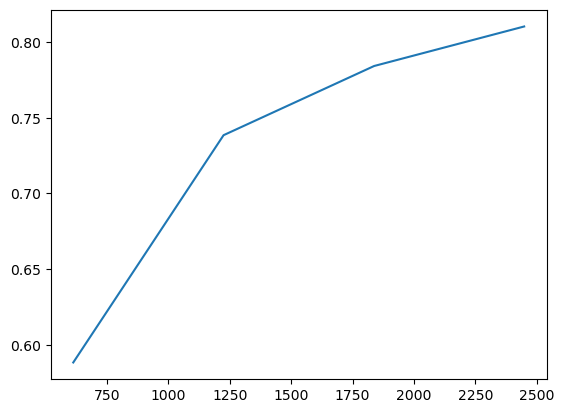

In [58]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

# Pruebas:

In [5]:
ft_model = ''
tweet = """ el pp no han querido derogar en diciembre de 2021, 
ni en febrero 2023 una ley trans autonomica en la comunidad de madrid que pone en riesgo a los menores y 
ahora dicen que derogaran la nacional.
yo no entiendo nada, de nada. """
res = openai.Completion.create(model=ft_model, prompt=tweet, max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

'\n\nvox -> vox -> vox -> vox -> v'

In [14]:
ft_model = ''
tweet = """ Lo más grave es escuchar a ministros del Gobierno malmetiendo sin saber quién compone la comisión que decide el contenido de las pruebas. 

Empezando por la ministra de Educación. 

Viven desde y para el activismo político.. """
res = openai.Completion.create(model=ft_model, prompt=tweet, max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' '

In [21]:
ft_model = ''
tweet = """ amor. """
res = openai.Completion.create(model=ft_model, prompt=tweet, max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

'   #votaseguro -> vox -> vox 28'